In [10]:
# %%
# ===========================
# 1) IMPORTS ET LIBRAIRIES
# ===========================

import os
import gpxpy
import gpxpy.gpx
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import pandas as pd
import time
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# On essaie d'importer folium pour la création de carte
try:
    import folium
    from folium.plugins import MarkerCluster
    FOLIUM_AVAILABLE = True
except ImportError:
    print("Folium n'est pas installé. Exécutez `pip install folium` pour la carte.")
    FOLIUM_AVAILABLE = False


In [11]:
# %%
# ===========================
# 2) FONCTIONS UTILITAIRES
# ===========================

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calcule l'angle de direction (bearing) entre deux points géographiques.
    Retourne l'angle en degrés (0-360).
    """
    # Conversion en radians
    lat1, lon1 = math.radians(lat1), math.radians(lon1)
    lat2, lon2 = math.radians(lat2), math.radians(lon2)
    
    # Calcul du bearing
    y = math.sin(lon2 - lon1) * math.cos(lat2)
    x = (math.cos(lat1) * math.sin(lat2) 
         - math.sin(lat1) * math.cos(lat2) * math.cos(lon2 - lon1))
    bearing = math.degrees(math.atan2(y, x))
    
    # Normalisation entre 0 et 360 degrés
    bearing = (bearing + 360) % 360
    return bearing

def angle_difference(bearing1, bearing2):
    """
    Calcule la différence d'angle entre deux directions (bearing1, bearing2),
    et renvoie un angle entre 0 et 180.
    
    - 0 => même direction (pas de virage)
    - 180 => demi-tour
    """
    diff = abs(bearing1 - bearing2) % 360
    return min(diff, 360 - diff)


In [12]:
# %%
# ===========================
# 3) ANALYSE DÉTAILLÉE 
# ===========================
def analyze_segments_details(segments, turn_threshold_deg=25):
    """
    Analyse chaque segment pour retourner un DataFrame avec:
      - Distance (km)
      - Nombre de virages (>= turn_threshold_deg)
      - Virages/km
      - Angles moyens / max (optionnel)
      - etc.
    """
    stats = []
    for i, seg_points in enumerate(segments):
        if len(seg_points) < 2:
            stats.append({
                "Segment": i+1,
                "Distance (km)": 0.0,
                "Nombre de virages": 0,
                "Virages/km": 0,
            })
            continue
        
        # Calcul distance & bearings
        dist_seg = 0.0
        bears_seg = []
        for j in range(len(seg_points)-1):
            p1 = seg_points[j]
            p2 = seg_points[j+1]
            d = geodesic((p1.latitude, p1.longitude), (p2.latitude, p2.longitude)).km
            dist_seg += d
            b = calculate_bearing(p1.latitude, p1.longitude, p2.latitude, p2.longitude)
            bears_seg.append(b)
        
        # Comptage virages
        nb_turns = 0
        for j in range(1, len(bears_seg)):
            diff = angle_difference(bears_seg[j-1], bears_seg[j])
            if diff >= turn_threshold_deg:
                nb_turns += 1
        
        vpkm = nb_turns/dist_seg if dist_seg>0 else 0
        
        stats.append({
            "Segment": i+1,
            "Distance (km)": round(dist_seg,2),
            "Nombre de virages": nb_turns,
            "Virages/km": round(vpkm,2)
        })
    
    return pd.DataFrame(stats)


In [13]:
# %%
# ==================================
# 4) FONCTION DE CRÉATION DE CARTE
# ==================================
def visualize_segments_on_map(segments, addresses, output_html="segment_map.html", method_name="Method", mark_finish=True):
    """
    Crée un fichier HTML avec une carte Folium affichant chaque segment.
    - segments: liste de listes de points GPX
    - addresses: dataFrame ou liste de dicts avec 
          { "Segment": i, "Latitude": lat, "Longitude": lon, "Adresse": ... }
    - output_html: nom du fichier HTML de sortie
    - method_name: pour le titre/tooltip ("Greedy" ou "DP", par ex.)
    - mark_finish: si True, on ajoute un marqueur "Arrivée" au dernier point du dernier segment
    """
    if not FOLIUM_AVAILABLE:
        print("Folium n'est pas disponible. Carte non créée.")
        return
    
    if len(segments) == 0:
        print("Aucun segment, impossible de créer la carte.")
        return
    
    # Déterminer un centre approximatif (on prend le 1er point)
    first_pt = segments[0][0]
    m = folium.Map(location=[first_pt.latitude, first_pt.longitude], zoom_start=10)
    
    # MarkerCluster pour les départs
    marker_cluster = MarkerCluster(name="Départs de segments").add_to(m)
    
    colors = ["blue","red","green","purple","orange","darkred","darkblue","darkgreen",
              "cadetblue","lightred","darkpurple","pink","lightblue","lightgreen","gray","black"]
    
    # Plot de chaque segment
    for i, seg in enumerate(segments):
        # Récupère les coords
        coords = [(p.latitude, p.longitude) for p in seg]
        color = colors[i % len(colors)]
        
        # Trace la ligne
        folium.PolyLine(
            coords,
            color=color,
            weight=3,
            opacity=0.8,
            tooltip=f"{method_name} - Segment {i+1}"
        ).add_to(m)
        
        # Marqueur de départ
        if i < len(addresses):
            # On suppose que addresses[i] correspond au départ du segment i
            addr_info = addresses[i]
            lat0 = addr_info["Latitude"]
            lon0 = addr_info["Longitude"]
            popup_text = (f"<b>Segment {addr_info['Segment']}</b><br>"
                          f"Distance: {addr_info['Distance (km)']} km<br>"
                          f"Virages: {addr_info['Nombre de virages']}<br>"
                          f"Adresse: {addr_info['Adresse']}")
            
            folium.Marker(
                location=[lat0, lon0],
                popup=folium.Popup(popup_text, max_width=300),
                tooltip=f"Départ S{i+1}",
                icon=folium.Icon(color=color, icon="play")
            ).add_to(marker_cluster)
    
    # Marquer l'arrivée (dernier point du dernier segment)
    if mark_finish and len(segments[-1]) > 0:
        last_point = segments[-1][-1]
        folium.Marker(
            location=[last_point.latitude, last_point.longitude],
            popup="Arrivée",
            tooltip="Arrivée",
            icon=folium.Icon(color="red", icon="stop")
        ).add_to(m)
    
    # Ajouter la couche
    folium.LayerControl().add_to(m)
    
    # Sauvegarder
    m.save(output_html)
    print(f"Carte enregistrée: {output_html}")
    
    return m


In [14]:
# %%
# =================================================
# 5) APPROCHE 1: ALGO "GREEDY" (Minimiser localement)
# =================================================

def split_gpx_greedy(
    input_gpx_file, 
    min_segment_length_km=5.0,
    max_segment_length_km=15.0,
    turn_threshold_deg=25,  # pour stats
    output_directory="Relais_gpx_greedy",
    output_excel_file="segments_addresses_greedy.xlsx",
    detailed_stats_file="detailed_segment_stats_greedy.xlsx",
    map_html_file="segment_map_greedy.html"
):
    # Créer le dossier de sortie si besoin
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Charger le fichier GPX
    with open(input_gpx_file, "r") as f:
        gpx = gpxpy.parse(f)
    print(f"[GREEDY] Fichier GPX chargé : {input_gpx_file}")
    
    # Récupérer tous les points
    all_points = []
    for track in gpx.tracks:
        for segment in track.segments:
            all_points.extend(segment.points)
    print(f"[GREEDY] Nombre total de points : {len(all_points)}")
    
    if len(all_points) < 2:
        print("[GREEDY] Trop peu de points. Abandon.")
        return [], []
    
    # Distances cumulées & bearings
    distances = [0.0]
    bearings = [0.0]
    total_distance = 0.0
    for i in range(len(all_points) - 1):
        p1 = all_points[i]
        p2 = all_points[i+1]
        dist_km = geodesic((p1.latitude, p1.longitude), (p2.latitude, p2.longitude)).km
        total_distance += dist_km
        distances.append(total_distance)
        
        b = calculate_bearing(p1.latitude, p1.longitude, p2.latitude, p2.longitude)
        bearings.append(b)
    
    print(f"[GREEDY] Distance totale : {total_distance:.2f} km")
    
    segments_indices = [0]
    current_idx = 0
    
    while True:
        start_dist = distances[current_idx]
        candidates = []
        for j in range(current_idx+1, len(all_points)):
            dist_j = distances[j] - start_dist
            if dist_j > max_segment_length_km:
                break
            if dist_j >= min_segment_length_km:
                candidates.append(j)
        
        if not candidates:
            if current_idx < len(all_points) - 1:
                segments_indices.append(len(all_points)-1)
            break
        
        # Choix du j qui minimise l'angle de virage
        best_j = None
        best_angle = 180.0
        for j in candidates:
            if j < len(all_points) - 1:
                # bearing i->j
                lat_i, lon_i = all_points[current_idx].latitude, all_points[current_idx].longitude
                lat_j, lon_j = all_points[j].latitude, all_points[j].longitude
                bearing_1 = calculate_bearing(lat_i, lon_i, lat_j, lon_j)
                bearing_2 = bearings[j]  # direction j->j+1
                turn = angle_difference(bearing_1, bearing_2)
            else:
                turn = 0  # dernier point
            
            if turn < best_angle:
                best_angle = turn
                best_j = j
        
        segments_indices.append(best_j)
        current_idx = best_j
        if current_idx >= len(all_points) - 1:
            break
    
    # Construction des segments
    segments = []
    segment_start_points = []
    for i in range(len(segments_indices)-1):
        start_i = segments_indices[i]
        end_i = segments_indices[i+1]
        seg_points = all_points[start_i:end_i+1]
        segments.append(seg_points)
        
        if seg_points:
            lat0 = seg_points[0].latitude
            lon0 = seg_points[0].longitude
            segment_start_points.append((lat0, lon0))
    
    print(f"[GREEDY] Nombre de segments : {len(segments)}")
    
    # Calcul stats "simples"
    segment_lengths = []
    segment_turns = []
    for seg in segments:
        if len(seg) < 2:
            segment_lengths.append(0.0)
            segment_turns.append(0)
            continue
        dist_seg = 0.0
        bears_seg = []
        for i in range(len(seg)-1):
            p1 = seg[i]
            p2 = seg[i+1]
            dist_km = geodesic((p1.latitude, p1.longitude), (p2.latitude, p2.longitude)).km
            dist_seg += dist_km
            b = calculate_bearing(p1.latitude, p1.longitude, p2.latitude, p2.longitude)
            bears_seg.append(b)
        
        # Virages
        nb_turn = 0
        for i in range(1, len(bears_seg)):
            diff = angle_difference(bears_seg[i-1], bears_seg[i])
            if diff >= turn_threshold_deg:
                nb_turn += 1
        
        segment_lengths.append(dist_seg)
        segment_turns.append(nb_turn)
    
    # Impression
    for i,(d,t) in enumerate(zip(segment_lengths, segment_turns)):
        print(f"[GREEDY] Segment {i+1} : {d:.2f} km, {t} virage(s) >= {turn_threshold_deg}°")
    
    # Géocodage inversé + Excel
    geolocator = Nominatim(user_agent="gpx_segment_splitter_greedy", timeout=10)
    def reverse_geocode_with_retry(lat, lon, max_retries=3, delay=2):
        for attempt in range(max_retries):
            try:
                location = geolocator.reverse((lat, lon))
                return location.address if location else "Adresse introuvable"
            except Exception as e:
                if attempt < max_retries - 1:
                    time.sleep(delay)
                    delay *= 1.5
                else:
                    return f"Erreur: {str(e)[:100]}"
    
    segment_addresses = []
    print("[GREEDY] Géocodage des segments...")
    for idx, (lat, lon) in enumerate(tqdm(segment_start_points)):
        address = reverse_geocode_with_retry(lat, lon)
        dist_val = round(segment_lengths[idx],2)
        turn_val = segment_turns[idx]
        seg_data = {
            "Segment": idx+1,
            "Latitude": lat,
            "Longitude": lon,
            "Distance (km)": dist_val,
            "Nombre de virages": turn_val,
            "Virages/km": round(turn_val/dist_val, 2) if dist_val>0 else "N/A",
            "Adresse": address
        }
        segment_addresses.append(seg_data)
        time.sleep(1)
    
    df = pd.DataFrame(segment_addresses)
    filename = os.path.join(output_directory, output_excel_file)
    df.to_excel(filename, index=False)
    print(f"[GREEDY] Excel sauvegardé : {output_excel_file}")
    
    # Export GPX
    print("[GREEDY] Export des segments GPX...")
    for idx, segpts in enumerate(segments):
        new_gpx = gpxpy.gpx.GPX()
        new_track = gpxpy.gpx.GPXTrack()
        new_gpx.tracks.append(new_track)
        new_segment = gpxpy.gpx.GPXTrackSegment()
        new_track.segments.append(new_segment)
        
        for pt in segpts:
            new_segment.points.append(pt)
        
        out_file = os.path.join(output_directory, f"relai_{idx+1}.gpx")
        with open(out_file, "w") as f:
            f.write(new_gpx.to_xml())
    
    print(f"[GREEDY] {len(segments)} fichiers GPX créés dans : {output_directory}")
    
    # Graphique simple
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.bar(range(1,len(segment_lengths)+1), segment_lengths)
    plt.axhline(y=min_segment_length_km, color='r', linestyle='--', label=f"Min {min_segment_length_km} km")
    plt.axhline(y=max_segment_length_km, color='r', linestyle='--', label=f"Max {max_segment_length_km} km")
    plt.xlabel("Segments")
    plt.ylabel("Distance (km)")
    plt.title("Distance par segment (Greedy)")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.bar(range(1,len(segment_turns)+1), segment_turns)
    plt.xlabel("Segments")
    plt.ylabel(f"Virages >= {turn_threshold_deg}°")
    plt.title("Virages par segment (Greedy)")
    
    plt.tight_layout()
    png_file = os.path.join(output_directory, "stats_greedy.png")
    plt.savefig(png_file)
    plt.show()
    print(f"[GREEDY] Graphique sauvegardé : {png_file}")
    
    # Analyse détaillée + export
    print("[GREEDY] Analyse détaillée des segments...")
    detailed_df = analyze_segments_details(segments, turn_threshold_deg)
    detailed_df.to_excel(os.path.join(output_directory, detailed_stats_file), index=False)
    print(f"[GREEDY] Fichier détaillé sauvegardé : {detailed_stats_file}")
    
    # Carte Folium
    if FOLIUM_AVAILABLE:
        print("[GREEDY] Création de la carte Folium...")
        # On transforme segment_addresses en un format plus direct pour la fonction map
        # On y ajoute "Adresse" déjà présent, etc.
        # visualize_segments_on_map() attend "Distance (km)" et "Nombre de virages" ...
        # On a déjà tout dans segment_addresses :)
        map_file = os.path.join(output_directory, map_html_file)
        visualize_segments_on_map(
            segments, 
            addresses=segment_addresses,
            output_html=map_file,
            method_name="Greedy",
            mark_finish=True
        )
    
    return segments, segment_addresses


In [15]:
# %%
# ==============================================
# 6) APPROCHE 2: PROGRAMMATION DYNAMIQUE (DP)
# ==============================================
from fileinput import filename


def split_gpx_dp(
    input_gpx_file,
    min_segment_length_km=5.0,
    max_segment_length_km=15.0,
    turn_threshold_deg=25,  
    output_directory="Relais_gpx_dp",
    output_excel_file="segments_addresses_dp.xlsx",
    detailed_stats_file="detailed_segment_stats_dp.xlsx",
    map_html_file="segment_map_dp.html"
):
    """
    Minimisation globale (somme des angles de coupe).
    Peut être très coûteux si on a beaucoup de points.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Charger GPX
    with open(input_gpx_file, "r") as f:
        gpx = gpxpy.parse(f)
    print(f"[DP] Fichier GPX chargé : {input_gpx_file}")
    
    # Extraire points
    all_points = []
    for track in gpx.tracks:
        for seg in track.segments:
            all_points.extend(seg.points)
    print(f"[DP] Nombre total de points : {len(all_points)}")
    if len(all_points) < 2:
        print("[DP] Trop peu de points. Abandon.")
        return [], []
    
    # Distances cumulées
    distances = [0.0]
    total_dist = 0.0
    for i in range(len(all_points)-1):
        p1 = all_points[i]
        p2 = all_points[i+1]
        d = geodesic((p1.latitude, p1.longitude),(p2.latitude,p2.longitude)).km
        total_dist += d
        distances.append(total_dist)
    print(f"[DP] Distance totale : {total_dist:.2f} km")
    
    # Bearings
    bearings = [0.0]
    for i in range(len(all_points)-1):
        p1 = all_points[i]
        p2 = all_points[i+1]
        b = calculate_bearing(p1.latitude, p1.longitude, p2.latitude, p2.longitude)
        bearings.append(b)
    
    n = len(all_points)
    
    def cut_angle(i, j):
        """Angle si on coupe en j après i (i->j, j->j+1)."""
        if j >= n-1:
            return 0
        lat_i, lon_i = all_points[i].latitude, all_points[i].longitude
        lat_j, lon_j = all_points[j].latitude, all_points[j].longitude
        b1 = calculate_bearing(lat_i, lon_i, lat_j, lon_j)
        b2 = bearings[j]
        return angle_difference(b1, b2)
    
    dp = [math.inf]*n
    dp[0] = 0
    parent = [-1]*n
    
    # DP O(n^2) potentiellement
    for i in range(n-1):
        if dp[i] == math.inf:
            continue
        dist_start = distances[i]
        j0 = i+1
        while j0 < n:
            dist_ij = distances[j0] - dist_start
            if dist_ij > max_segment_length_km:
                break
            if dist_ij >= min_segment_length_km:
                cost_angle = cut_angle(i, j0)
                new_cost = dp[i] + cost_angle
                if new_cost < dp[j0]:
                    dp[j0] = new_cost
                    parent[j0] = i
            j0 += 1
    
    # Reconstruction
    end_idx = n-1
    if dp[end_idx] == math.inf:
        # chercher le best possible < n-1
        best_val = math.inf
        best_idx = 0
        for i in range(n):
            if dp[i]<best_val:
                best_val = dp[i]
                best_idx = i
        end_idx = best_idx
    
    path_idx = []
    cur = end_idx
    while cur!=-1 and cur!=0:
        path_idx.append(cur)
        cur = parent[cur]
    path_idx.append(0)
    path_idx.reverse()
    
    if path_idx[-1] != n-1:
        path_idx.append(n-1)
    
    # Construire segments
    segments = []
    segment_start_points = []
    for i in range(len(path_idx)-1):
        start_i = path_idx[i]
        end_i = path_idx[i+1]
        seg_points = all_points[start_i:end_i+1]
        segments.append(seg_points)
        if seg_points:
            lat0 = seg_points[0].latitude
            lon0 = seg_points[0].longitude
            segment_start_points.append((lat0, lon0))
    
    print(f"[DP] Nombre de segments : {len(segments)}")
    
    # Stats simple
    segment_lengths = []
    segment_turns = []
    for seg in segments:
        if len(seg)<2:
            segment_lengths.append(0.0)
            segment_turns.append(0)
            continue
        dist_seg = 0.0
        bears_seg = []
        for i in range(len(seg)-1):
            p1 = seg[i]
            p2 = seg[i+1]
            dd = geodesic((p1.latitude,p1.longitude),(p2.latitude,p2.longitude)).km
            dist_seg += dd
            b = calculate_bearing(p1.latitude,p1.longitude,p2.latitude,p2.longitude)
            bears_seg.append(b)
        # compter virages
        nb_turn=0
        for i in range(1,len(bears_seg)):
            diff = angle_difference(bears_seg[i-1], bears_seg[i])
            if diff>=turn_threshold_deg:
                nb_turn+=1
        segment_lengths.append(dist_seg)
        segment_turns.append(nb_turn)
    
    for i,(d,t) in enumerate(zip(segment_lengths,segment_turns)):
        print(f"[DP] Segment {i+1}: {d:.2f} km, {t} virage(s) >= {turn_threshold_deg}°")
    
    # Géocodage
    geolocator = Nominatim(user_agent="gpx_segment_splitter_dp", timeout=10)
    def reverse_geocode_with_retry(lat, lon, max_retries=3, delay=2):
        for attempt in range(max_retries):
            try:
                location = geolocator.reverse((lat, lon))
                return location.address if location else "Adresse introuvable"
            except Exception as e:
                if attempt < max_retries - 1:
                    time.sleep(delay)
                    delay *= 1.5
                else:
                    return f"Erreur: {str(e)[:100]}"
    
    segment_addresses = []
    print("[DP] Géocodage des segments...")
    for idx, (lat, lon) in enumerate(tqdm(segment_start_points)):
        address = reverse_geocode_with_retry(lat, lon)
        dist_val = round(segment_lengths[idx],2)
        turn_val = segment_turns[idx]
        seg_data = {
            "Segment": idx+1,
            "Latitude": lat,
            "Longitude": lon,
            "Distance (km)": dist_val,
            "Nombre de virages": turn_val,
            "Virages/km": round(turn_val/dist_val, 2) if dist_val>0 else "N/A",
            "Adresse": address
        }
        segment_addresses.append(seg_data)
        time.sleep(1)
    
    df = pd.DataFrame(segment_addresses)
    filename = os.path.join(output_directory, output_excel_file)
    df.to_excel(filename, index=False)
    print(f"[DP] Excel sauvegardé : {filename}")
    
    # Export GPX
    print("[DP] Export des segments GPX...")
    for idx, segpts in enumerate(segments):
        new_gpx = gpxpy.gpx.GPX()
        new_track = gpxpy.gpx.GPXTrack()
        new_gpx.tracks.append(new_track)
        new_segment = gpxpy.gpx.GPXTrackSegment()
        new_track.segments.append(new_segment)
        
        for pt in segpts:
            new_segment.points.append(pt)
        
        out_file = os.path.join(output_directory, f"relai_{idx+1}.gpx")
        with open(out_file,"w") as f:
            f.write(new_gpx.to_xml())
    
    print(f"[DP] {len(segments)} fichiers GPX créés dans : {output_directory}")
    
    # Graphique
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.bar(range(1,len(segment_lengths)+1), segment_lengths)
    plt.axhline(y=min_segment_length_km, color='r', linestyle='--', label=f"Min {min_segment_length_km} km")
    plt.axhline(y=max_segment_length_km, color='r', linestyle='--', label=f"Max {max_segment_length_km} km")
    plt.xlabel("Segments (DP)")
    plt.ylabel("Distance (km)")
    plt.title("Distance par segment (DP)")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.bar(range(1,len(segment_turns)+1), segment_turns)
    plt.xlabel("Segments (DP)")
    plt.ylabel(f"Virages >= {turn_threshold_deg}°")
    plt.title("Virages par segment (DP)")
    
    plt.tight_layout()
    png_file = os.path.join(output_directory, "stats_dp.png")
    plt.savefig(png_file)
    plt.show()
    print(f"[DP] Graphique sauvegardé : {png_file}")
    
    # Analyse détaillée + export
    print("[DP] Analyse détaillée des segments...")
    detailed_df = analyze_segments_details(segments, turn_threshold_deg)
    detailed_df_path = os.path.join(output_directory, detailed_stats_file)
    detailed_df.to_excel(detailed_df_path, index=False)
    print(f"[DP] Fichier détaillé sauvegardé : {detailed_df_path}")
    
    # Carte Folium
    if FOLIUM_AVAILABLE:
        print("[DP] Création de la carte Folium...")
        map_file = os.path.join(output_directory, map_html_file)
        visualize_segments_on_map(
            segments,
            addresses=segment_addresses,
            output_html=map_file,
            method_name="DP",
            mark_finish=True
        )
    
    return segments, segment_addresses


In [16]:
# %%
# =============================================================
# 7) NOUVELLE APPROCHE: OPTIMISATION PAR MINIMISATION DES VIRAGES
# =============================================================

def split_gpx_optimize_turns(
    input_gpx_file, 
    min_segment_length_km=3.0,    # Réduction pour plus de flexibilité
    max_segment_length_km=20.0,   # Augmentation pour permettre des segments plus longs sans virage
    turn_threshold_deg=25,        # seuil pour considérer un changement comme un virage
    output_directory="Relais_gpx_optimized",
    output_excel_file="segments_addresses_optimized.xlsx",
    detailed_stats_file="detailed_segment_stats_optimized.xlsx",
    map_html_file="segment_map_optimized.html"
):
    """
    Optimisation focalisée sur la minimisation des virages.
    Cette approche cherche à créer des segments avec le minimum de virages possible,
    quitte à créer plus de segments ou à avoir des segments de longueur variable.
    """
    # Créer le dossier de sortie si besoin
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Charger le fichier GPX
    with open(input_gpx_file, "r") as f:
        gpx = gpxpy.parse(f)
    print(f"[OPTIMIZE] Fichier GPX chargé : {input_gpx_file}")
    
    # Récupérer tous les points
    all_points = []
    for track in gpx.tracks:
        for segment in track.segments:
            all_points.extend(segment.points)
    print(f"[OPTIMIZE] Nombre total de points : {len(all_points)}")
    
    if len(all_points) < 2:
        print("[OPTIMIZE] Trop peu de points. Abandon.")
        return [], []
    
    # Distances cumulées & bearings
    distances = [0.0]
    bearings = []
    total_distance = 0.0
    
    # Calculer les distances et les bearings
    for i in range(len(all_points) - 1):
        p1 = all_points[i]
        p2 = all_points[i+1]
        dist_km = geodesic((p1.latitude, p1.longitude), (p2.latitude, p2.longitude)).km
        total_distance += dist_km
        distances.append(total_distance)
        
        b = calculate_bearing(p1.latitude, p1.longitude, p2.latitude, p2.longitude)
        bearings.append(b)
    
    # Ajouter un bearing factice à la fin pour éviter les indexing errors
    bearings.append(bearings[-1] if bearings else 0.0)
    
    print(f"[OPTIMIZE] Distance totale : {total_distance:.2f} km")
    
    # Identifier les points de virage significatifs
    turn_points = []
    for i in range(1, len(bearings)-1):
        angle_diff = angle_difference(bearings[i-1], bearings[i])
        if angle_diff >= turn_threshold_deg:
            # C'est un virage significatif
            turn_points.append(i)
    
    print(f"[OPTIMIZE] Nombre de virages significatifs (>= {turn_threshold_deg}°) détectés : {len(turn_points)}")
    
    # Créer des segments en tenant compte des contraintes de distance et de virages
    segments_indices = [0]  # Commencer par le premier point
    current_idx = 0
    
    while current_idx < len(all_points) - 1:
        # Trouver le prochain point de section optimal
        best_end_idx = None
        lowest_turns = float('inf')
        
        # Explorer les distances possibles depuis le point actuel
        start_dist = distances[current_idx]
        
        # 1. Chercher le segment qui minimise le nombre de virages
        for end_idx in range(current_idx + 1, len(all_points)):
            segment_dist = distances[end_idx] - start_dist
            
            # Ne pas dépasser la distance maximale
            if segment_dist > max_segment_length_km:
                break
                
            # Vérifier la distance minimale
            if segment_dist < min_segment_length_km:
                continue
            
            # Compter les virages dans ce segment potentiel
            segment_turns = 0
            for turn_idx in turn_points:
                if current_idx < turn_idx <= end_idx:
                    segment_turns += 1
            
            # Si on trouve un segment sans virage, le choisir immédiatement
            if segment_turns == 0:
                best_end_idx = end_idx
                lowest_turns = 0
                
                # Essayer d'étendre ce segment sans virage autant que possible
                while (end_idx + 1 < len(all_points) and 
                       distances[end_idx + 1] - start_dist <= max_segment_length_km):
                    # Vérifier si l'ajout du point suivant introduit un virage
                    if end_idx + 1 in turn_points:
                        break
                    end_idx += 1
                    best_end_idx = end_idx
                
                break  # Segment parfait trouvé
            
            # Sinon, choisir le segment avec le moins de virages
            if segment_turns < lowest_turns:
                lowest_turns = segment_turns
                best_end_idx = end_idx
        
        # Si aucun segment valide n'a été trouvé, prendre le minimum acceptable
        if best_end_idx is None:
            for end_idx in range(current_idx + 1, len(all_points)):
                segment_dist = distances[end_idx] - start_dist
                if segment_dist >= min_segment_length_km:
                    best_end_idx = end_idx
                    break
            
            # Si toujours pas de solution, prendre le dernier point
            if best_end_idx is None:
                best_end_idx = len(all_points) - 1
        
        segments_indices.append(best_end_idx)
        current_idx = best_end_idx
        
        if current_idx >= len(all_points) - 1:
            break
    
    # S'assurer que le dernier point est inclus
    if segments_indices[-1] != len(all_points) - 1:
        segments_indices.append(len(all_points) - 1)
    
    # Construction des segments
    segments = []
    segment_start_points = []
    for i in range(len(segments_indices) - 1):
        start_i = segments_indices[i]
        end_i = segments_indices[i+1]
        seg_points = all_points[start_i:end_i+1]
        segments.append(seg_points)
        
        if seg_points:
            lat0 = seg_points[0].latitude
            lon0 = seg_points[0].longitude
            segment_start_points.append((lat0, lon0))
    
    print(f"[OPTIMIZE] Nombre de segments créés : {len(segments)}")
    
    # Calcul stats des segments
    segment_lengths = []
    segment_turns = []
    for seg in segments:
        if len(seg) < 2:
            segment_lengths.append(0.0)
            segment_turns.append(0)
            continue
        
        dist_seg = 0.0
        bears_seg = []
        for i in range(len(seg)-1):
            p1 = seg[i]
            p2 = seg[i+1]
            dist_km = geodesic((p1.latitude, p1.longitude), (p2.latitude, p2.longitude)).km
            dist_seg += dist_km
            b = calculate_bearing(p1.latitude, p1.longitude, p2.latitude, p2.longitude)
            bears_seg.append(b)
        
        # Comptage des virages
        nb_turn = 0
        for i in range(1, len(bears_seg)):
            diff = angle_difference(bears_seg[i-1], bears_seg[i])
            if diff >= turn_threshold_deg:
                nb_turn += 1
        
        segment_lengths.append(dist_seg)
        segment_turns.append(nb_turn)
    
    # Affichage des segments
    avg_turns_per_km = sum(segment_turns) / sum(segment_lengths) if sum(segment_lengths) > 0 else 0
    print(f"[OPTIMIZE] Moyenne de virages par km: {avg_turns_per_km:.2f}")
    print(f"[OPTIMIZE] Nombre total de virages: {sum(segment_turns)}")
    
    for i, (d, t) in enumerate(zip(segment_lengths, segment_turns)):
        vpkm = t/d if d > 0 else 0
        print(f"[OPTIMIZE] Segment {i+1}: {d:.2f} km, {t} virage(s) ≥ {turn_threshold_deg}°, {vpkm:.2f} virages/km")
    
    # Géocodage inversé + Excel
    geolocator = Nominatim(user_agent="gpx_segment_splitter_optimize", timeout=10)
    def reverse_geocode_with_retry(lat, lon, max_retries=3, delay=2):
        for attempt in range(max_retries):
            try:
                location = geolocator.reverse((lat, lon))
                return location.address if location else "Adresse introuvable"
            except Exception as e:
                if attempt < max_retries - 1:
                    time.sleep(delay)
                    delay *= 1.5
                else:
                    return f"Erreur: {str(e)[:100]}"
    
    segment_addresses = []
    print("[OPTIMIZE] Géocodage des segments...")
    for idx, (lat, lon) in enumerate(tqdm(segment_start_points)):
        address = reverse_geocode_with_retry(lat, lon)
        dist_val = round(segment_lengths[idx], 2)
        turn_val = segment_turns[idx]
        vpkm = turn_val/dist_val if dist_val > 0 else 0
        
        seg_data = {
            "Segment": idx+1,
            "Latitude": lat,
            "Longitude": lon,
            "Distance (km)": dist_val,
            "Nombre de virages": turn_val,
            "Virages/km": round(vpkm, 2),
            "Adresse": address
        }
        segment_addresses.append(seg_data)
        time.sleep(1)
    
    df = pd.DataFrame(segment_addresses)
    filename = os.path.join(output_directory, output_excel_file)
    df.to_excel(filename, index=False)
    print(f"[OPTIMIZE] Excel sauvegardé : {filename}")
    
    # Export GPX
    print("[OPTIMIZE] Export des segments GPX...")
    for idx, segpts in enumerate(segments):
        new_gpx = gpxpy.gpx.GPX()
        new_track = gpxpy.gpx.GPXTrack()
        new_gpx.tracks.append(new_track)
        new_segment = gpxpy.gpx.GPXTrackSegment()
        new_track.segments.append(new_segment)
        
        for pt in segpts:
            new_segment.points.append(pt)
        
        out_file = os.path.join(output_directory, f"relai_{idx+1}.gpx")
        with open(out_file, "w") as f:
            f.write(new_gpx.to_xml())
    
    print(f"[OPTIMIZE] {len(segments)} fichiers GPX créés dans : {output_directory}")
    
    # Graphique comparatif
    plt.figure(figsize=(16, 8))
    
    # Distance par segment
    plt.subplot(2, 2, 1)
    plt.bar(range(1, len(segment_lengths)+1), segment_lengths)
    plt.axhline(y=min_segment_length_km, color='r', linestyle='--', label=f"Min {min_segment_length_km} km")
    plt.axhline(y=max_segment_length_km, color='r', linestyle='--', label=f"Max {max_segment_length_km} km")
    plt.xlabel("Segments")
    plt.ylabel("Distance (km)")
    plt.title("Distance par segment (Optimisé)")
    plt.legend()
    
    # Virages par segment
    plt.subplot(2, 2, 2)
    plt.bar(range(1, len(segment_turns)+1), segment_turns)
    plt.xlabel("Segments")
    plt.ylabel(f"Virages >= {turn_threshold_deg}°")
    plt.title("Virages par segment (Optimisé)")
    
    # Virages par km
    plt.subplot(2, 2, 3)
    v_per_km = [t/d if d > 0 else 0 for t, d in zip(segment_turns, segment_lengths)]
    plt.bar(range(1, len(v_per_km)+1), v_per_km)
    plt.xlabel("Segments")
    plt.ylabel("Virages/km")
    plt.title("Densité de virages par segment (Optimisé)")
    
    # Distribution des virages
    plt.subplot(2, 2, 4)
    plt.hist(segment_turns, bins=range(0, max(segment_turns)+2), align='left', rwidth=0.8)
    plt.xlabel("Nombre de virages")
    plt.ylabel("Nombre de segments")
    plt.title("Distribution des virages par segment (Optimisé)")
    
    plt.tight_layout()
    png_file = os.path.join(output_directory, "stats_optimized.png")
    plt.savefig(png_file)
    plt.show()
    print(f"[OPTIMIZE] Graphique sauvegardé : {png_file}")
    
    # Analyse détaillée + export
    print("[OPTIMIZE] Analyse détaillée des segments...")
    detailed_df = analyze_segments_details(segments, turn_threshold_deg)
    detailed_df.to_excel(os.path.join(output_directory, detailed_stats_file), index=False)
    print(f"[OPTIMIZE] Fichier détaillé sauvegardé : {detailed_stats_file}")
    
    # Carte Folium
    if FOLIUM_AVAILABLE:
        print("[OPTIMIZE] Création de la carte Folium...")
        map_file = os.path.join(output_directory, map_html_file)
        visualize_segments_on_map(
            segments, 
            addresses=segment_addresses,
            output_html=map_file,
            method_name="Optimisé",
            mark_finish=True
        )
    
    return segments, segment_addresses


In [17]:
# %%
# ============================================================
# 8) NOUVELLE APPROCHE: "ReuseSegments" => Autorise la REVISITE
# ============================================================
#
# On considère un graph complet (ou presque) sur les points [0..n-1].
# Il y a une arête i->j si distance(i->j) dans [min_km, max_km].
# Le coût de l'arête i->j = angle en j (sauf j == n-1 => 0).
# On applique un algorithme de plus court chemin (Dijkstra).
# On peut revisiter des nœuds si c'est vraiment avantageux 
# pour diminuer la somme totale d'angles.
# 
# ATTENTION: si le GPX est très grand (50k points), 
# la complexité peut devenir énorme. 
# Filtrez éventuellement les points avant.

import heapq

def split_gpx_reuse_segments(
    input_gpx_file,
    min_segment_length_km=5.0,
    max_segment_length_km=15.0,
    turn_threshold_deg=25,  # pour stats, pas pour le calcul direct
    output_directory="Relais_gpx_reuse",
    output_excel_file="segments_addresses_reuse.xlsx",
    detailed_stats_file="detailed_segment_stats_reuse.xlsx",
    map_html_file="segment_map_reuse.html"
):
    """Permet de REVISITER des nœuds pour réduire la somme d'angles."""
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # 1) Charger le GPX
    with open(input_gpx_file, "r") as f:
        gpx = gpxpy.parse(f)
    print(f"[REUSE] Fichier GPX chargé : {input_gpx_file}")
    
    # Récupérer les points
    all_points = []
    for track in gpx.tracks:
        for seg in track.segments:
            all_points.extend(seg.points)
    n = len(all_points)
    print(f"[REUSE] Nombre total de points : {n}")
    if n<2:
        print("[REUSE] Trop peu de points, abandon.")
        return [], []
    
    # 2) Distances cumulées et bearings
    #    On s'en sert juste pour calculer la distance(i->j) 
    #    et le bearing i->i+1, etc.
    latlon = [(p.latitude, p.longitude) for p in all_points]
    
    def distance(i, j):
        return geodesic(latlon[i], latlon[j]).km
    
    # bearing pour i->i+1 
    # => on recalcule plus tard i->j si besoin
    # (mais i->j n'est pas forcément i->i+1)
    def bearing(i, j):
        lat1, lon1 = latlon[i]
        lat2, lon2 = latlon[j]
        return calculate_bearing(lat1, lon1, lat2, lon2)
    
    # 3) Construire la liste d'adjacence du graphe
    #    edges[i] = liste des (j, cost) tels que 
    #               dist(i->j) in [min_segment_length_km, max_segment_length_km]
    #    cost = angle en j, i.e. angle(i->j, j->j+1) 
    #    => on a besoin du bearing i->j et j->j+1
    #    => si j == n-1 => cost=0 (fin)
    
    # On calcule "bearing j->j+1" pour l'utiliser
    end_bearing = 0
    bearing_j_next = [0]*(n)
    for j in range(n-1):
        bearing_j_next[j] = bearing(j, j+1)
    bearing_j_next[n-1] = end_bearing
    
    # Construction edges
    edges = [[] for _ in range(n)]
    
    # Pour chaque i, on regarde j>i
    # Attention: c'est potentiellement O(n^2), 
    # ce qui peut être lourd si n > 10k
    for i in range(n):
        # On peut limiter la recherche de j (ex: i+1..i+500) si c'est trop grand
        for j in range(i+1, n):
            dist_ij = distance(i,j)
            if dist_ij>max_segment_length_km:
                break  # car j+1 sera encore plus loin
            if dist_ij>=min_segment_length_km:
                # calcul angle
                if j< n-1:
                    # angle(i->j, j->j+1)
                    b1 = bearing(i,j)
                    b2 = bearing_j_next[j]
                    cost_angle = angle_difference(b1, b2)
                else:
                    cost_angle = 0  # fin
                edges[i].append((j, cost_angle))
    
    # 4) Algorithme de plus court chemin (Dijkstra)
    #    dp[i] = coût minimal (somme d'angles) pour aller de 0 à i
    #    On autorise la revisite, tant que ça améliore dp[i].
    
    dp = [math.inf]*n
    dp[0] = 0
    parent = [-1]*n
    
    # min-heap de (cost, node)
    heap = [(0, 0)]
    
    while heap:
        current_cost, i = heapq.heappop(heap)
        if current_cost>dp[i]:
            continue
        if i == n-1:
            break  # on a atteint la fin
        # Parcourir les voisins
        for (j, cost_angle) in edges[i]:
            new_cost = current_cost + cost_angle
            if new_cost < dp[j]:
                dp[j] = new_cost
                parent[j] = i
                heapq.heappush(heap, (new_cost, j))
    
    if dp[n-1] == math.inf:
        print("[REUSE] Pas de chemin pour atteindre le dernier point.")
        # On cherche le plus loin qu'on peut atteindre
        best_idx = 0
        best_val = 0
        for i in range(n):
            if dp[i]<math.inf and i>best_idx:
                best_idx = i
                best_val = dp[i]
        end_idx = best_idx
        print(f"[REUSE] On s'arrêtera à i={end_idx}, cost={best_val}")
    else:
        end_idx = n-1
    
    # 5) Reconstruction du chemin
    path_nodes = []
    cur = end_idx
    while cur!=-1:
        path_nodes.append(cur)
        cur = parent[cur]
    path_nodes.reverse()  # on part de 0 vers end
    
    # 6) Construction des segments
    segments = []
    segment_start_points = []
    for k in range(len(path_nodes)-1):
        i = path_nodes[k]
        j = path_nodes[k+1]
        seg_pts = all_points[i:j+1]
        segments.append(seg_pts)
        lat0 = seg_pts[0].latitude
        lon0 = seg_pts[0].longitude
        segment_start_points.append((lat0, lon0))
    
    print(f"[REUSE] Nombre de segments = {len(segments)} (chemin autorisant revisite)")
    
    # 7) Stats sur ces segments
    segment_lengths = []
    segment_turns = []
    for seg in segments:
        if len(seg)<2:
            segment_lengths.append(0.0)
            segment_turns.append(0)
            continue
        dist_seg = 0.0
        bears_seg = []
        for i in range(len(seg)-1):
            p1 = seg[i]
            p2 = seg[i+1]
            d_km = geodesic((p1.latitude,p1.longitude),(p2.latitude,p2.longitude)).km
            dist_seg += d_km
            b = calculate_bearing(p1.latitude,p1.longitude,p2.latitude,p2.longitude)
            bears_seg.append(b)
        
        nb_turn=0
        for i in range(1,len(bears_seg)):
            diff = angle_difference(bears_seg[i-1], bears_seg[i])
            if diff>=turn_threshold_deg:
                nb_turn+=1
        segment_lengths.append(dist_seg)
        segment_turns.append(nb_turn)
    
    for i,(d,t) in enumerate(zip(segment_lengths,segment_turns)):
        print(f"[REUSE] Segment {i+1}: {d:.2f} km, {t} virage(s) >= {turn_threshold_deg}°")
    
    # 8) Géocodage inverse
    geolocator = Nominatim(user_agent="gpx_segment_splitter_reuse", timeout=10)
    
    def reverse_geocode_with_retry(lat, lon, max_retries=3, delay=2):
        for attempt in range(max_retries):
            try:
                location = geolocator.reverse((lat, lon))
                return location.address if location else "Adresse introuvable"
            except Exception as e:
                if attempt<max_retries-1:
                    time.sleep(delay)
                    delay*=1.5
                else:
                    return f"Erreur: {str(e)[:100]}"
    
    segment_addresses = []
    for idx, (lat, lon) in enumerate(tqdm(segment_start_points, desc="[REUSE] Géocodage")):
        address = reverse_geocode_with_retry(lat, lon)
        dist_val = round(segment_lengths[idx],2)
        turn_val = segment_turns[idx]
        seg_data = {
            "Segment": idx+1,
            "Latitude": lat,
            "Longitude": lon,
            "Distance (km)": dist_val,
            "Nombre de virages": turn_val,
            "Virages/km": round(turn_val/dist_val, 2) if dist_val>0 else "N/A",
            "Adresse": address
        }
        segment_addresses.append(seg_data)
        time.sleep(1)
    
    df = pd.DataFrame(segment_addresses)
    df.to_excel(output_excel_file, index=False)
    print(f"[REUSE] Excel sauvegardé: {output_excel_file}")
    
    # 9) Export GPX
    for idx, segpts in enumerate(segments):
        new_gpx = gpxpy.gpx.GPX()
        new_track = gpxpy.gpx.GPXTrack()
        new_gpx.tracks.append(new_track)
        new_segment = gpxpy.gpx.GPXTrackSegment()
        new_track.segments.append(new_segment)
        
        for pt in segpts:
            new_segment.points.append(pt)
        
        out_file = os.path.join(output_directory, f"relai_{idx+1}.gpx")
        with open(out_file, "w") as f:
            f.write(new_gpx.to_xml())
    
    print(f"[REUSE] {len(segments)} segments GPX créés dans: {output_directory}")
    
    # 10) Graphiques
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.bar(range(1,len(segment_lengths)+1), segment_lengths)
    plt.axhline(y=min_segment_length_km, color='r', linestyle='--', label=f"Min {min_segment_length_km} km")
    plt.axhline(y=max_segment_length_km, color='r', linestyle='--', label=f"Max {max_segment_length_km} km")
    plt.xlabel("Segments (REUSE)")
    plt.ylabel("Distance (km)")
    plt.title("Distance par segment (REUSE)")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.bar(range(1,len(segment_turns)+1), segment_turns)
    plt.xlabel("Segments (REUSE)")
    plt.ylabel(f"Virages >= {turn_threshold_deg}°")
    plt.title("Virages par segment (REUSE)")
    
    plt.tight_layout()
    graph_file = os.path.join(output_directory, "stats_reuse.png")
    plt.savefig(graph_file)
    plt.show()
    print(f"[REUSE] Graphique sauvegardé: {graph_file}")
    
    # 11) Analyse détaillée + export
    detailed_df = analyze_segments_details(segments, turn_threshold_deg)
    detailed_df_path = os.path.join(output_directory, detailed_stats_file)
    detailed_df.to_excel(detailed_df_path, index=False)
    print(f"[REUSE] Stats détaillées: {detailed_df_path}")
    
    # 12) Carte Folium
    if FOLIUM_AVAILABLE:
        map_file = os.path.join(output_directory, map_html_file)
        visualize_segments_on_map(
            segments,
            addresses=segment_addresses,
            output_html=map_file,
            method_name="ReuseSegments",
            mark_finish=True
        )
    
    return segments, segment_addresses


In [21]:
def split_gpx_chinese_postman_segments(
    input_gpx_file = "eulerian_circuit_final_chinese.gpx",
    min_segment_length_km=5.0,
    max_segment_length_km=15.0,
    turn_threshold_deg=25,
    output_directory="Relais_gpx_chinese",
    output_excel_file="segments_addresses_chinese.xlsx",
    detailed_stats_file="detailed_segment_stats_chinese.xlsx",
    map_html_file="segment_map_chinese.html"
):
    """
    Lit le GPX généré par l'algo 'Chinese Postman modifié',
    puis découpe le long tracé en segments [min_km..max_km],
    en cherchant à couper là où l'angle de virage est le plus faible.
    
    Crée:
      - un dossier 'Relais_gpx_chinese' avec relai_1.gpx, relai_2.gpx, ...
      - un Excel segments_addresses_chinese.xlsx
      - un fichier stats_chinese.png
      - un detailed_segment_stats_chinese.xlsx
      - une carte segment_map_chinese.html (si folium dispo)
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # 1) Chargement du GPX
    with open(input_gpx_file, "r") as f:
        gpx = gpxpy.parse(f)
    print(f"[CHINESE] Fichier GPX chargé: {input_gpx_file}")
    
    # Récupérer tous les points du GPX (fusion des tracks/segments)
    all_points = []
    for track in gpx.tracks:
        for seg in track.segments:
            all_points.extend(seg.points)
    
    print(f"[CHINESE] Nombre total de points: {len(all_points)}")
    if len(all_points)<2:
        print("[CHINESE] Trop peu de points pour découper.")
        return [], []
    
    # 2) Distances cumulées + bearings
    distances = [0.0]
    total_dist = 0.0
    bearings = [0.0]  # bearings[i] = direction (pt_i->pt_{i+1})
    
    for i in range(len(all_points)-1):
        p1 = all_points[i]
        p2 = all_points[i+1]
        d = geodesic((p1.latitude, p1.longitude),(p2.latitude, p2.longitude)).km
        total_dist += d
        distances.append(total_dist)
        
        b = calculate_bearing(p1.latitude, p1.longitude, p2.latitude, p2.longitude)
        bearings.append(b)
    
    print(f"[CHINESE] Distance totale: {total_dist:.2f} km")
    
    # 3) Découpage "greedy angle" => segments_idx
    segments_idx = [0]
    current_idx = 0
    
    def local_turn_angle(i, j):
        """
        Angle de virage si on coupe en j => angle( i->j , j->j+1 )
        Si j== dernier, 0
        """
        if j >= len(all_points)-1:
            return 0
        # bearing i->j
        p_i = all_points[i]
        p_j = all_points[j]
        b1 = calculate_bearing(p_i.latitude, p_i.longitude, p_j.latitude, p_j.longitude)
        # bearing j->j+1
        b2 = bearings[j]
        return angle_difference(b1, b2)
    
    while True:
        start_dist = distances[current_idx]
        candidates = []
        
        # Cherche j tel que distance(i->j) dans [min..max]
        for j in range(current_idx+1, len(all_points)):
            dist_j = distances[j] - start_dist
            if dist_j > max_segment_length_km:
                break
            if dist_j >= min_segment_length_km:
                candidates.append(j)
        
        if not candidates:
            # plus de candidats => fin
            if current_idx < len(all_points)-1:
                segments_idx.append(len(all_points)-1)
            break
        
        # on choisit le j où l'angle de virage est minimal
        best_j = None
        best_angle = 180.0
        for j in candidates:
            angle_j = local_turn_angle(current_idx, j)
            if angle_j < best_angle:
                best_angle = angle_j
                best_j = j
        
        segments_idx.append(best_j)
        current_idx = best_j
        if current_idx >= len(all_points)-1:
            break
    
    # 4) Construction des segments effectifs
    segments = []
    segment_start_points = []
    for k in range(len(segments_idx)-1):
        start_i = segments_idx[k]
        end_i   = segments_idx[k+1]
        seg_pts = all_points[start_i:end_i+1]
        segments.append(seg_pts)
        
        if seg_pts:
            lat0 = seg_pts[0].latitude
            lon0 = seg_pts[0].longitude
            segment_start_points.append((lat0, lon0))
    
    print(f"[CHINESE] Nombre de segments crées: {len(segments)}")
    
    # 5) Stats de base
    segment_lengths = []
    segment_turns   = []
    for seg in segments:
        if len(seg)<2:
            segment_lengths.append(0)
            segment_turns.append(0)
            continue
        dist_seg = 0.0
        brs = []
        for i in range(len(seg)-1):
            p1 = seg[i]
            p2 = seg[i+1]
            dist_seg += geodesic((p1.latitude,p1.longitude),(p2.latitude,p2.longitude)).km
            b = calculate_bearing(p1.latitude,p1.longitude,p2.latitude,p2.longitude)
            brs.append(b)
        
        nb_t = 0
        for i in range(1,len(brs)):
            diff = angle_difference(brs[i-1], brs[i])
            if diff>=turn_threshold_deg:
                nb_t+=1
        
        segment_lengths.append(dist_seg)
        segment_turns.append(nb_t)
    
    for i,(dist_,turn_) in enumerate(zip(segment_lengths, segment_turns)):
        print(f"[CHINESE] Segment {i+1}: {dist_:.2f} km, {turn_} virages >= {turn_threshold_deg}°")
    
    # 6) Géocodage + Excel
    geolocator = Nominatim(user_agent="chinese_splitter", timeout=10)
    
    def reverse_geocode_with_retry(lat, lon, max_retries=3, delay=2):
        for attempt in range(max_retries):
            try:
                loc = geolocator.reverse((lat, lon))
                return loc.address if loc else "Adresse introuvable"
            except Exception as e:
                if attempt<max_retries-1:
                    time.sleep(delay)
                    delay *=1.5
                else:
                    return f"Erreur: {str(e)[:100]}"
    
    segment_addresses = []
    for idx, (lat, lon) in enumerate(tqdm(segment_start_points, desc="[CHINESE] Géocodage")):
        addr = reverse_geocode_with_retry(lat, lon)
        dist_val = round(segment_lengths[idx],2)
        turn_val = segment_turns[idx]
        seg_data = {
            "Segment": idx+1,
            "Latitude": lat,
            "Longitude": lon,
            "Distance (km)": dist_val,
            "Nombre de virages": turn_val,
            "Virages/km": round(turn_val/dist_val,2) if dist_val>0 else "N/A",
            "Adresse": addr
        }
        segment_addresses.append(seg_data)
        time.sleep(1)  # pour éviter trop de requêtes simultanées
    
    df = pd.DataFrame(segment_addresses)
    df.to_excel(os.path.join(output_directory, output_excel_file), index=False)
    print(f"[CHINESE] Excel sauvegardé: {output_excel_file}")
    
    # 7) Export GPX par segment
    for idx, segpts in enumerate(segments):
        new_gpx = gpxpy.gpx.GPX()
        new_track = gpxpy.gpx.GPXTrack()
        new_gpx.tracks.append(new_track)
        new_segment = gpxpy.gpx.GPXTrackSegment()
        new_track.segments.append(new_segment)
        
        for pt in segpts:
            new_segment.points.append(pt)
        
        out_gpx = os.path.join(output_directory, f"relai_{idx+1}.gpx")
        with open(out_gpx, "w") as f:
            f.write(new_gpx.to_xml())
    
    print(f"[CHINESE] {len(segments)} fichiers GPX créés dans: {output_directory}")
    
    # 8) Graphique de base
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.bar(range(1,len(segment_lengths)+1), segment_lengths)
    plt.axhline(y=min_segment_length_km, color='r', linestyle='--', label=f"Min {min_segment_length_km} km")
    plt.axhline(y=max_segment_length_km, color='r', linestyle='--', label=f"Max {max_segment_length_km} km")
    plt.xlabel("Segments (CHINESE)")
    plt.ylabel("Distance (km)")
    plt.title("Distance par segment (CHINESE)")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.bar(range(1,len(segment_turns)+1), segment_turns)
    plt.xlabel("Segments (CHINESE)")
    plt.ylabel(f"Virages >= {turn_threshold_deg}°")
    plt.title("Virages par segment (CHINESE)")
    
    plt.tight_layout()
    png_file = os.path.join(output_directory, "stats_chinese.png")
    plt.savefig(png_file)
    plt.show()
    print(f"[CHINESE] Graphique sauvegardé: {png_file}")
    
    # 9) Analyse détaillée
    #    On convertit chaque segment en la liste de points "GPXTrackPoint"
    #    pour feed analyze_segments_details
    detailed_df = analyze_segments_details(segments, turn_threshold_deg)
    detailed_path = os.path.join(output_directory, detailed_stats_file)
    detailed_df.to_excel(detailed_path, index=False)
    print(f"[CHINESE] Fichier détaillé sauvegardé: {detailed_path}")
    
    # 10) Carte Folium
    if FOLIUM_AVAILABLE:
        map_file = os.path.join(output_directory, map_html_file)
        visualize_segments_on_map(
            segments, addresses=segment_addresses,
            output_html=map_file,
            method_name="Chinese",
            mark_finish=True
        )
    
    return segments, segment_addresses

In [18]:
# %%
# =============================================
# 8) UTILISATION DE L'OPTIMISATION DES VIRAGES
# =============================================

# Chemin de votre fichier GPX
input_gpx_file = "eulerian_circuit_final_chinese.gpx"  # <-- à adapter

# Paramètres pour la découpe
min_km = 5.0
max_km = 15.0
turn_threshold_deg = 40


In [ ]:

# =====================
# A) Approche Greedy
# =====================
segments_greedy, addresses_greedy = split_gpx_greedy(
    input_gpx_file=input_gpx_file,
    min_segment_length_km=min_km,
    max_segment_length_km=max_km,
    turn_threshold_deg=turn_threshold_deg,
    output_directory="Relais_gpx_greedy",
    output_excel_file="segments_addresses_greedy.xlsx",
    detailed_stats_file="detailed_segment_stats_greedy.xlsx",
    map_html_file="segment_map_greedy.html"
)


[GREEDY] Fichier GPX chargé : eulerian_circuit_final_chinese.gpx
[GREEDY] Nombre total de points : 219033
[GREEDY] Distance totale : 9593.69 km
[GREEDY] Nombre de segments : 995
[GREEDY] Segment 1 : 10.33 km, 270 virage(s) >= 40°
[GREEDY] Segment 2 : 6.85 km, 157 virage(s) >= 40°
[GREEDY] Segment 3 : 12.20 km, 110 virage(s) >= 40°
[GREEDY] Segment 4 : 5.31 km, 65 virage(s) >= 40°
[GREEDY] Segment 5 : 12.57 km, 139 virage(s) >= 40°
[GREEDY] Segment 6 : 5.35 km, 44 virage(s) >= 40°
[GREEDY] Segment 7 : 11.44 km, 110 virage(s) >= 40°
[GREEDY] Segment 8 : 8.25 km, 68 virage(s) >= 40°
[GREEDY] Segment 9 : 6.62 km, 72 virage(s) >= 40°
[GREEDY] Segment 10 : 11.39 km, 305 virage(s) >= 40°
[GREEDY] Segment 11 : 8.85 km, 116 virage(s) >= 40°
[GREEDY] Segment 12 : 5.57 km, 191 virage(s) >= 40°
[GREEDY] Segment 13 : 11.42 km, 167 virage(s) >= 40°
[GREEDY] Segment 14 : 12.66 km, 163 virage(s) >= 40°
[GREEDY] Segment 15 : 13.40 km, 228 virage(s) >= 40°
[GREEDY] Segment 16 : 5.09 km, 80 virage(s) >= 

 37%|███▋      | 364/995 [11:30<17:05,  1.63s/it]   

In [ ]:

# =====================
# B) Approche DP
# =====================
segments_dp, addresses_dp = split_gpx_dp(
    input_gpx_file=input_gpx_file,
    min_segment_length_km=min_km,
    max_segment_length_km=max_km,
    turn_threshold_deg=turn_threshold_deg,
    output_directory="Relais_gpx_dp",
    output_excel_file="segments_addresses_dp.xlsx",
    detailed_stats_file="detailed_segment_stats_dp.xlsx",
    map_html_file="segment_map_dp.html"
)


In [ ]:

# =====================
# C) Approche Optimisée
# =====================
# Exécution de l'algorithme optimisé
segments_optimized, addresses_optimized = split_gpx_optimize_turns(
    input_gpx_file=input_gpx_file,
    min_segment_length_km=min_km,
    max_segment_length_km=max_km,
    turn_threshold_deg=turn_threshold_deg,
    output_directory="Relais_gpx_optimized",
    output_excel_file="segments_addresses_optimized.xlsx",
    detailed_stats_file="detailed_segment_stats_optimized.xlsx",
    map_html_file="segment_map_optimized.html"
)


In [ ]:

# D) REUSE SEGMENTS
segments_reuse, add_reuse = split_gpx_reuse_segments(
    input_gpx_file,
    min_segment_length_km=min_km,
    max_segment_length_km=max_km,
    turn_threshold_deg=turn_threshold_deg,
    output_directory="Relais_gpx_reuse",
    output_excel_file="segments_addresses_reuse.xlsx",
    detailed_stats_file="detailed_segment_stats_reuse.xlsx",
    map_html_file="segment_map_reuse.html"
)


[CHINESE] Fichier GPX chargé: eulerian_circuit_final_chinese.gpx
[CHINESE] Nombre total de points: 219033
[CHINESE] Distance totale: 9593.69 km
[CHINESE] Nombre de segments crées: 995
[CHINESE] Segment 1: 10.33 km, 270 virages >= 40°
[CHINESE] Segment 2: 6.85 km, 157 virages >= 40°
[CHINESE] Segment 3: 12.20 km, 110 virages >= 40°
[CHINESE] Segment 4: 5.31 km, 65 virages >= 40°
[CHINESE] Segment 5: 12.57 km, 139 virages >= 40°
[CHINESE] Segment 6: 5.35 km, 44 virages >= 40°
[CHINESE] Segment 7: 11.44 km, 110 virages >= 40°
[CHINESE] Segment 8: 8.25 km, 68 virages >= 40°
[CHINESE] Segment 9: 6.62 km, 72 virages >= 40°
[CHINESE] Segment 10: 11.39 km, 305 virages >= 40°
[CHINESE] Segment 11: 8.85 km, 116 virages >= 40°
[CHINESE] Segment 12: 5.57 km, 191 virages >= 40°
[CHINESE] Segment 13: 11.42 km, 167 virages >= 40°
[CHINESE] Segment 14: 12.66 km, 163 virages >= 40°
[CHINESE] Segment 15: 13.40 km, 228 virages >= 40°
[CHINESE] Segment 16: 5.09 km, 80 virages >= 40°
[CHINESE] Segment 17: 

[CHINESE] Géocodage: 100%|██████████| 995/995 [18:34<00:00,  1.12s/it]  


[CHINESE] Excel sauvegardé: segments_addresses_chinese.xlsx
[CHINESE] 995 fichiers GPX créés dans: Relais_gpx_chinese


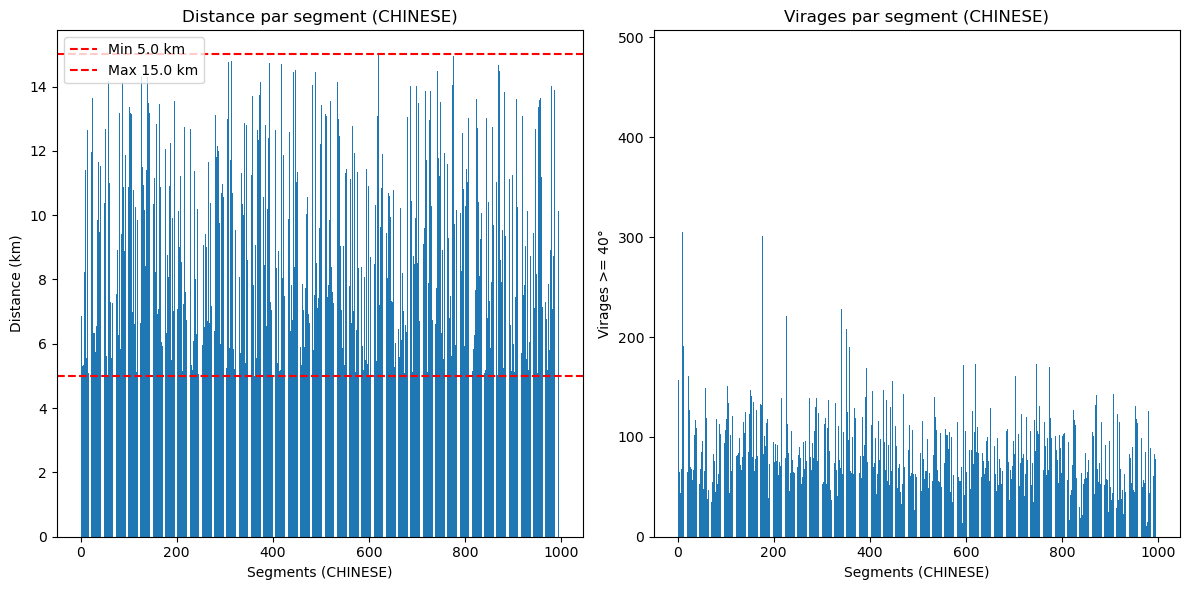

[CHINESE] Graphique sauvegardé: Relais_gpx_chinese/stats_chinese.png
[CHINESE] Fichier détaillé sauvegardé: Relais_gpx_chinese/detailed_segment_stats_chinese.xlsx
Carte enregistrée: Relais_gpx_chinese/segment_map_chinese.html


In [22]:
# E) CHINESE POSTMAN
segments_chinese, add_chinese = split_gpx_chinese_postman_segments(
    input_gpx_file,
    min_segment_length_km=min_km,
    max_segment_length_km=max_km,
    turn_threshold_deg=turn_threshold_deg,
    output_directory="Relais_gpx_chinese",
    output_excel_file="segments_addresses_chinese.xlsx",
    detailed_stats_file="detailed_segment_stats_chinese.xlsx",
    map_html_file="segment_map_chinese.html"
)

Fichier absent pour Reuse: Relais_gpx_reuse/segments_addresses_reuse.xlsx (méthode ignorée).
=== COMPARAISON DES MÉTHODES ===
 Méthode  Segments  Distance totale (km)  Nombre total de virages  Moy. Virages/km (par segment)  Moy. Virages/segment
  Greedy       190               1891.33                    36572                        19.2668                6.8928
      DP       188               1891.34                    36574                        19.2674                7.1506
Optimisé       377               1891.34                    36564                        19.3291                1.8209
 Chinese       995               9593.64                    89613                         9.3500                0.9583


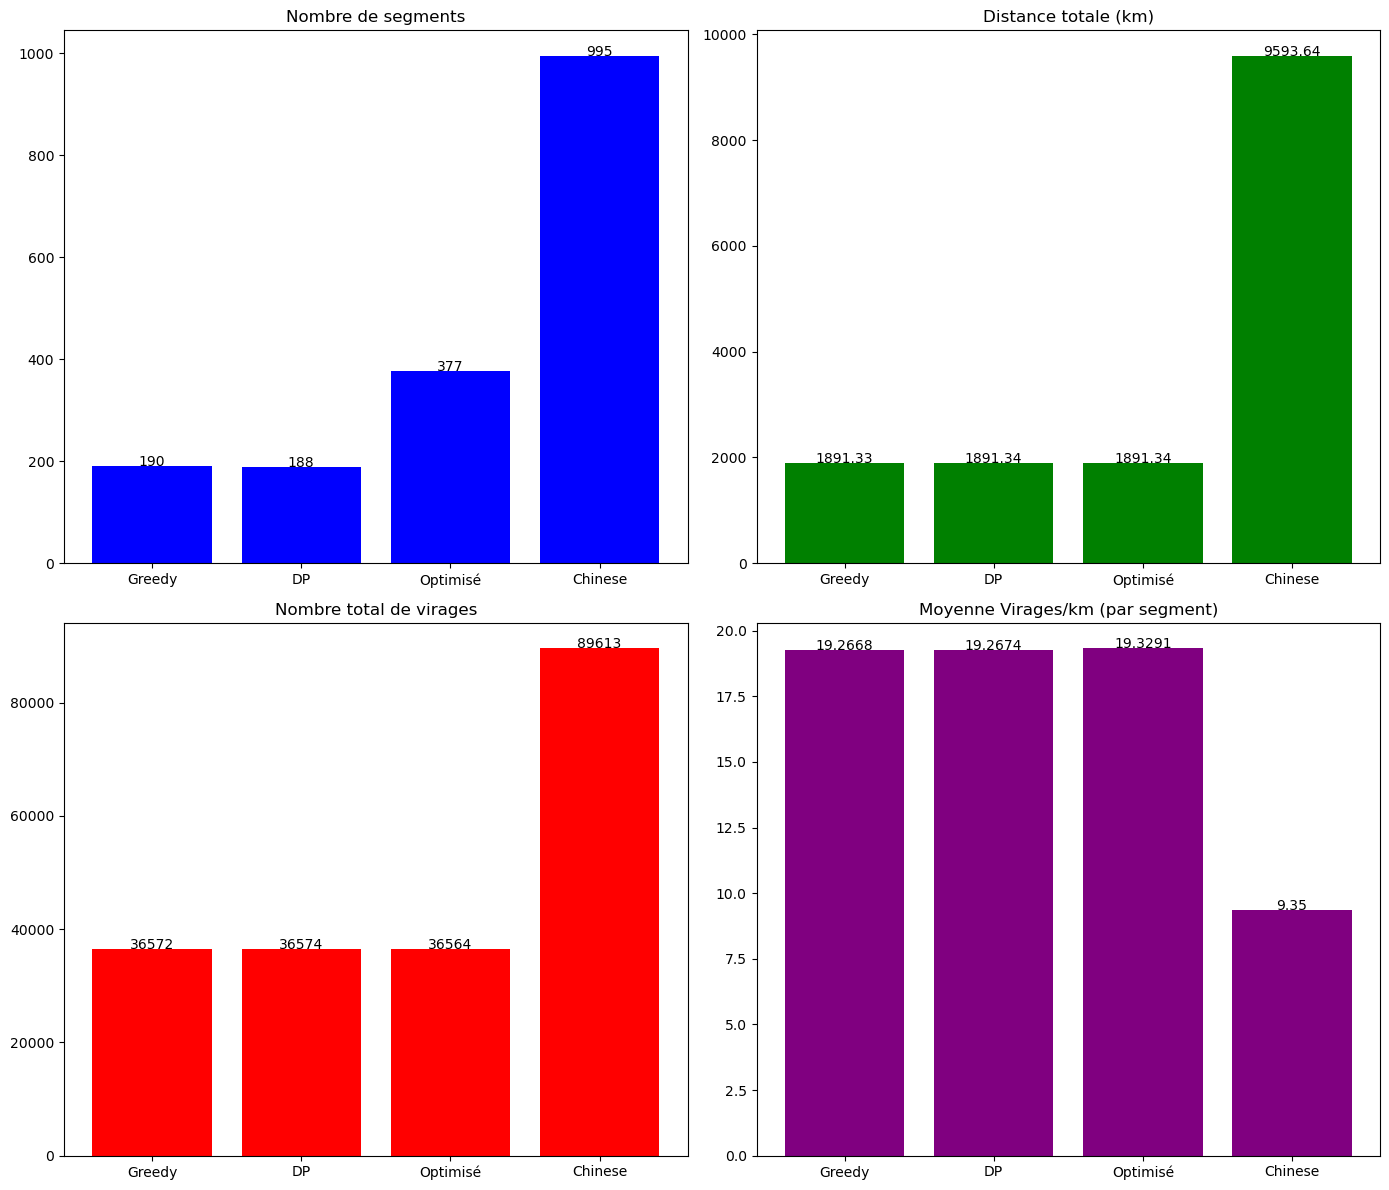

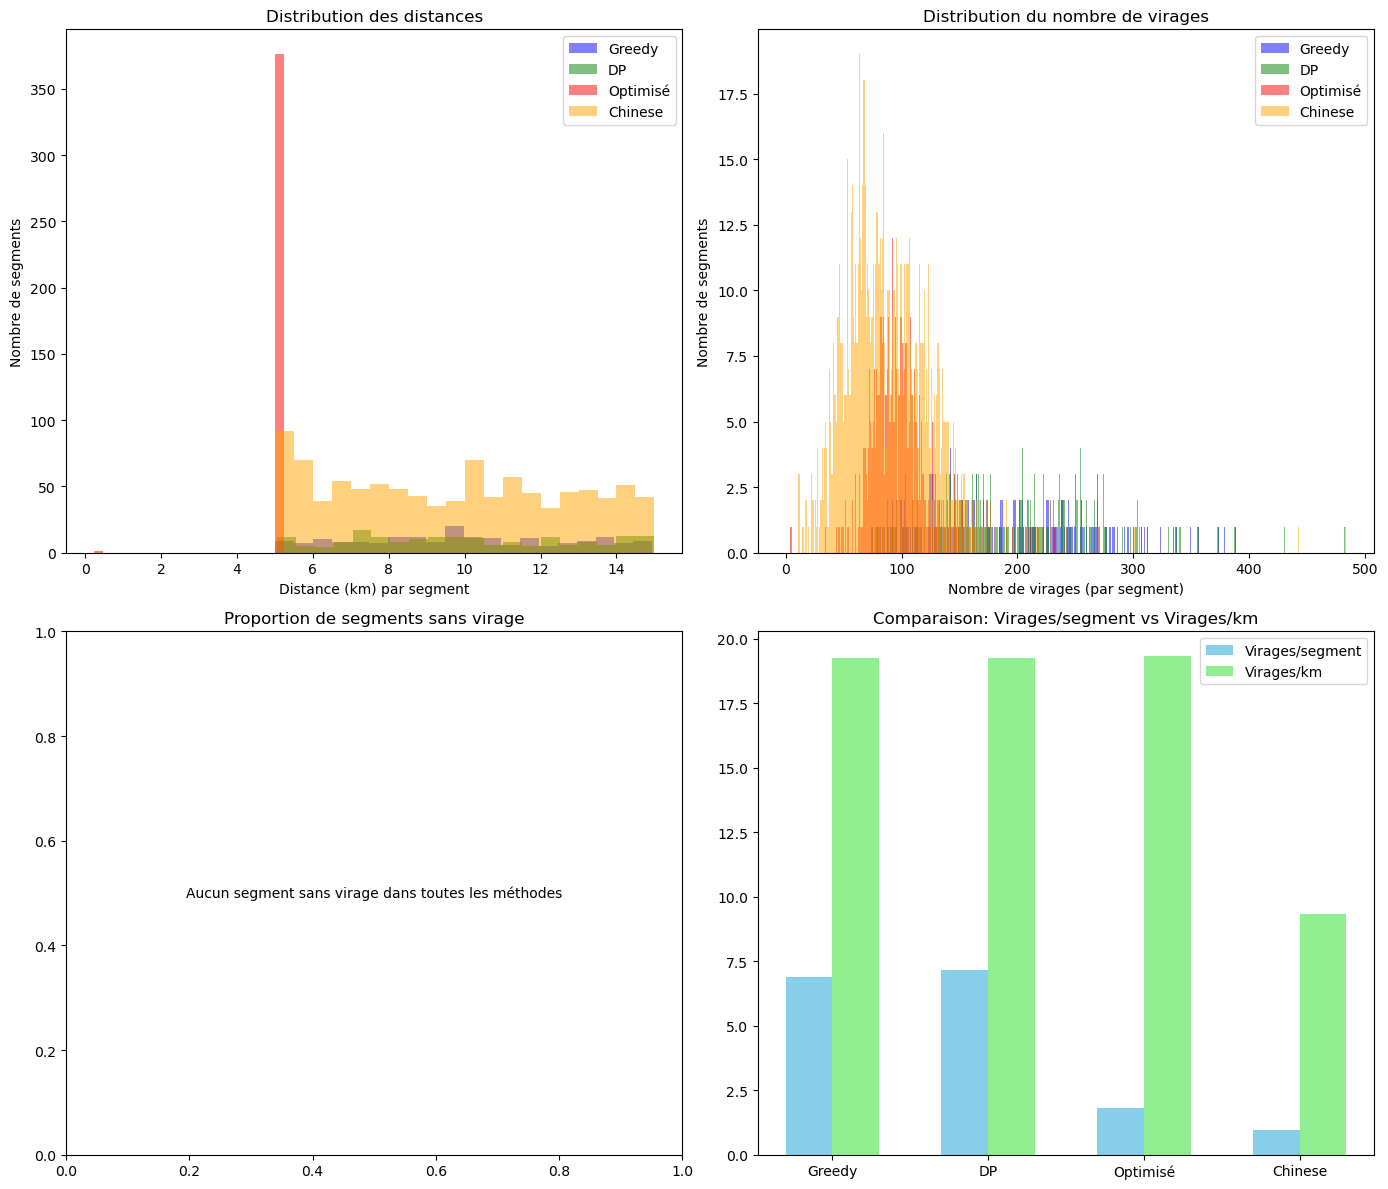

Fichier comparaison_methodes.xlsx créé.


In [23]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_methods_improved():
    """
    Compare les résultats de 4 méthodes de segmentation:
      - Greedy     (Relais_gpx_greedy/segments_addresses_greedy.xlsx)
      - DP         (Relais_gpx_dp/segments_addresses_dp.xlsx)
      - Optimisé   (Relais_gpx_optimized/segments_addresses_optimized.xlsx)
      - Reuse      (Relais_gpx_reuse/segments_addresses_reuse.xlsx)
      - Chinese    (Relais_gpx_chinese/segments_addresses_chinese.xlsx)
    
    Génère un dataframe de comparaison, des graphiques et un Excel 'comparaison_methodes.xlsx'.
    """
    # Association des noms de méthodes avec leurs chemins
    methods_info = {
        "Greedy":    "Relais_gpx_greedy/segments_addresses_greedy.xlsx",
        "DP":        "Relais_gpx_dp/segments_addresses_dp.xlsx",
        "Optimisé":  "Relais_gpx_optimized/segments_addresses_optimized.xlsx",
        "Reuse":     "Relais_gpx_reuse/segments_addresses_reuse.xlsx",
        "Chinese":   "Relais_gpx_chinese/segments_addresses_chinese.xlsx"
    }
    
    # Chargement des données
    dataframes = {}
    required_cols = ["Segment", "Distance (km)", "Nombre de virages"]
    
    for method_name, file_path in methods_info.items():
        if not os.path.exists(file_path):
            print(f"Fichier absent pour {method_name}: {file_path} (méthode ignorée).")
            continue
        
        try:
            df = pd.read_excel(file_path)
            
            # Vérifications des colonnes
            for col in required_cols:
                if col not in df.columns:
                    raise ValueError(f"{method_name}: Colonne manquante: {col}")
            
            # Nettoyage: si distance=0 => éviter la division par 0 pour "Virages/km"
            # On peut remplacer 0.0 par un epsilon, ou filtrer. Ici, on met un epsilon
            df["Distance (km)"] = df["Distance (km)"].replace(0, np.nan)
            
            # Calcul "Virages/km" par segment
            # => virages / distance ; si distance=NaN => virages/km = NaN
            df["Virages/km"] = df["Nombre de virages"] / df["Distance (km)"]
            
            # Calcul "Virages/segment" : on fait (nombreDeVirages / numéroDuSegment)
            # --> Ce n'est pas forcément très pertinent, 
            #     mais on garde la logique initiale (on pourrait l'omettre ou le changer)
            df["Virages/segment"] = df["Nombre de virages"] / df["Segment"]
            
            dataframes[method_name] = df
            
        except Exception as e:
            print(f"Erreur lors de la lecture/traitement de {file_path} pour {method_name}: {e}")
            continue
    
    # S'il n'y a pas au moins 1 méthode valide, on arrête
    if len(dataframes) == 0:
        print("Aucune méthode valide trouvée. Vérifiez vos fichiers.")
        return None
    
    # ========================
    # 1) TABLEAU COMPARATIF
    # ========================
    # On va calculer pour chaque méthode: 
    #   - nbSegments
    #   - distanceTotale
    #   - totalVirages
    #   - mean(Virages/km)
    #   - mean(Virages/segment)
    
    results = {
        "Méthode": [],
        "Segments": [],
        "Distance totale (km)": [],
        "Nombre total de virages": [],
        "Moy. Virages/km (par segment)": [],
        "Moy. Virages/segment": []
    }
    
    for method_name, df in dataframes.items():
        nb_segs = len(df)
        dist_tot = df["Distance (km)"].sum(skipna=True)  # ignorer NaN
        virages_tot = df["Nombre de virages"].sum(skipna=True)
        
        # Moyenne sur les segments existants
        vkm_mean = df["Virages/km"].mean(skipna=True)  # skip NaN
        vseg_mean = df["Virages/segment"].mean(skipna=True)
        
        results["Méthode"].append(method_name)
        results["Segments"].append(nb_segs)
        results["Distance totale (km)"].append(round(dist_tot, 2))
        results["Nombre total de virages"].append(int(virages_tot))
        results["Moy. Virages/km (par segment)"].append(round(vkm_mean, 4) if pd.notna(vkm_mean) else 0)
        results["Moy. Virages/segment"].append(round(vseg_mean, 4) if pd.notna(vseg_mean) else 0)
    
    df_comp = pd.DataFrame(results)
    # Tri par ordre (Greedy, DP, Optimisé, Reuse)
    ordre = ["Greedy", "DP", "Optimisé", "Reuse"]
    df_comp["order"] = df_comp["Méthode"].apply(lambda x: ordre.index(x) if x in ordre else 999)
    df_comp.sort_values("order", inplace=True)
    df_comp.drop(columns="order", inplace=True)
    df_comp.reset_index(drop=True, inplace=True)
    
    # Affichage
    print("=== COMPARAISON DES MÉTHODES ===")
    print(df_comp.to_string(index=False))
    
    # ==============================
    # 2) GRAPHES COMPARATIFS
    # ==============================
    # Bar chart 1: Nombre de segments
    plt.figure(figsize=(14, 12))
    
    plt.subplot(2,2,1)
    plt.bar(df_comp["Méthode"], df_comp["Segments"], color='blue')
    plt.title("Nombre de segments")
    for i, val in enumerate(df_comp["Segments"]):
        plt.text(i, val+0.05, str(val), ha='center')
    
    # Bar chart 2: Distance totale
    plt.subplot(2,2,2)
    plt.bar(df_comp["Méthode"], df_comp["Distance totale (km)"], color='green')
    plt.title("Distance totale (km)")
    for i, val in enumerate(df_comp["Distance totale (km)"]):
        plt.text(i, val+0.05, str(val), ha='center')
    
    # Bar chart 3: Nombre total de virages
    plt.subplot(2,2,3)
    plt.bar(df_comp["Méthode"], df_comp["Nombre total de virages"], color='red')
    plt.title("Nombre total de virages")
    for i, val in enumerate(df_comp["Nombre total de virages"]):
        plt.text(i, val+0.05, str(val), ha='center')
    
    # Bar chart 4: Moyenne Virages/km
    plt.subplot(2,2,4)
    plt.bar(df_comp["Méthode"], df_comp["Moy. Virages/km (par segment)"], color='purple')
    plt.title("Moyenne Virages/km (par segment)")
    for i, val in enumerate(df_comp["Moy. Virages/km (par segment)"]):
        plt.text(i, val+0.001, str(val), ha='center')
    
    plt.tight_layout()
    plt.savefig("comparaison_methodes_resume.png")
    plt.show()
    
    # ==============================
    # 3) DISTRIBUTIONS + CAMEMBERT
    # ==============================
    # On fait des histogrammes sur la DISTANCE et le NOMBRE DE VIRAGES
    plt.figure(figsize=(14, 12))
    # On prend toutes les méthodes qu'on a
    method_list = df_comp["Méthode"].tolist()
    colors = ["blue", "green", "red", "orange", "purple", "pink"]
    
    # Subplot 1: distribution des distances
    plt.subplot(2,2,1)
    bins = 20
    for i, mname in enumerate(method_list):
        df_m = dataframes[mname]
        # On filtre les distances valides
        dist_vals = df_m["Distance (km)"].dropna()
        if len(dist_vals) > 0:
            plt.hist(dist_vals, bins=bins, alpha=0.5, label=mname, color=colors[i % len(colors)])
    plt.xlabel("Distance (km) par segment")
    plt.ylabel("Nombre de segments")
    plt.title("Distribution des distances")
    plt.legend()
    
    # Subplot 2: distribution du nb de virages
    plt.subplot(2,2,2)
    for i, mname in enumerate(method_list):
        df_m = dataframes[mname]
        turn_vals = df_m["Nombre de virages"].dropna()
        if len(turn_vals) > 0:
            max_turn = int(turn_vals.max())
            bins_turn = range(0, max_turn + 2)
            plt.hist(turn_vals, bins=bins_turn, alpha=0.5, label=mname, color=colors[i % len(colors)])
    plt.xlabel("Nombre de virages (par segment)")
    plt.ylabel("Nombre de segments")
    plt.title("Distribution du nombre de virages")
    plt.legend()
    
    # Subplot 3: proportion de segments sans virage
    plt.subplot(2,2,3)
    no_turn_counts = []
    method_labels = []
    for i, mname in enumerate(method_list):
        df_m = dataframes[mname]
        zero_turn = (df_m["Nombre de virages"]==0).sum()
        no_turn_counts.append(zero_turn)
        method_labels.append(mname)
    total_no_turn = sum(no_turn_counts)
    if total_no_turn == 0:
        plt.text(0.5, 0.5, "Aucun segment sans virage dans toutes les méthodes", 
                 ha="center", va="center")
    else:
        plt.pie(no_turn_counts, labels=method_labels, autopct='%1.1f%%', startangle=140)
    plt.title("Proportion de segments sans virage")
    
    # Subplot 4: on compare Virages/segment VS Virages/km (moyennes)
    plt.subplot(2,2,4)
    x = np.arange(len(method_list))
    width = 0.3
    
    v_seg = df_comp["Moy. Virages/segment"].values
    v_km = df_comp["Moy. Virages/km (par segment)"].values
    
    plt.bar(x - width/2, v_seg, width, label="Virages/segment", color='skyblue')
    plt.bar(x + width/2, v_km, width, label="Virages/km", color='lightgreen')
    
    plt.xticks(x, method_list)
    plt.title("Comparaison: Virages/segment vs Virages/km")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("comparaison_methodes_distribution.png")
    plt.show()
    
    # ==============================
    # 4) SAUVEGARDE DES STATS
    # ==============================
    df_comp.to_excel("comparaison_methodes.xlsx", index=False)
    print("Fichier comparaison_methodes.xlsx créé.")
    
    return df_comp

comparison_stats = compare_methods_improved()